In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Training accuracies

In [52]:
mis_acc = pd.read_csv('/home/gridsan/arunas/broca/mistral/experiments/old-prompt/acc.csv')
mis_new_acc = pd.read_csv('/home/gridsan/arunas/broca/mistral/experiments/new-prompt/acc.csv')

In [46]:
mis_new_acc.index = mis_new_acc['type']

In [53]:
merged_df = pd.merge(mis_acc, mis_new_acc, on='type', how='outer')

In [57]:
merged_df = merged_df.rename(columns={'accuracy_x': 'mistral', 'accuracy_y': 'mistral (new prologue)'})
merged_df.index=merged_df['type']

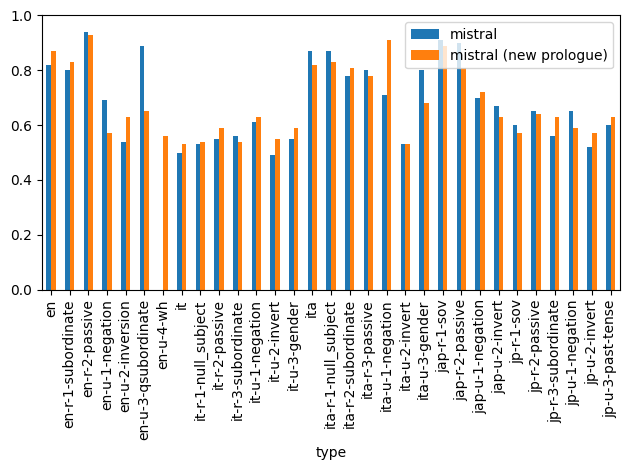

In [58]:
ax = merged_df.sort_index().plot.bar(rot=90)
ax.set_ylim(0, 1)
fig = ax.get_figure()
fig.tight_layout()
# ax.get_legend().remove()
# fig.savefig('/home/gridsan/arunas/broca/mistral/experiments/model-accuracies.png')



## Visualization of top 40 neurons

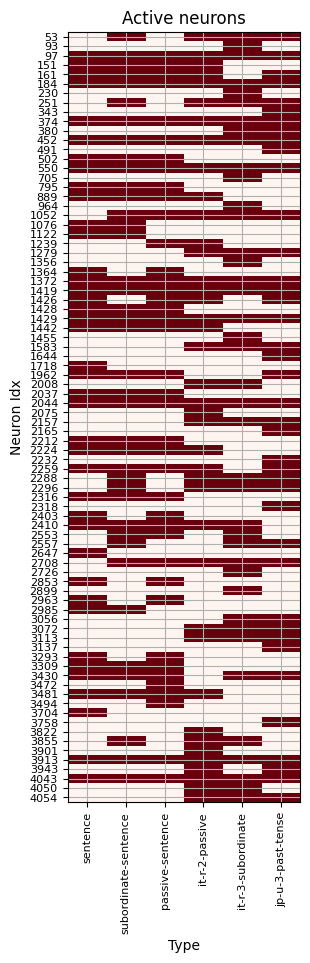

In [21]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']]

## Draw plots
plt.figure(figsize=(3, 10))
plt.imshow(mlp, cmap='Reds', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp.columns)), mlp.columns)
plt.yticks(range(len(mlp.index)), mlp.index)
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
plt.grid(True)
plt.title('Active neurons')
plt.xlabel('Type')
plt.ylabel('Neuron Idx')
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp.png')
plt.show()

<class 'int'>


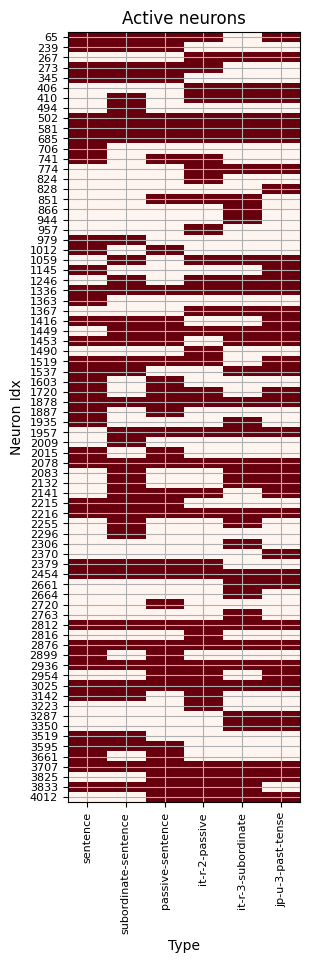

In [31]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
attn = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
attn['neuron'] = np.arange(0,4096)
attn[columns] = 0
attn['layer'] = 31
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/{col}.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            attn.loc[(attn['neuron'] == row['neuron']) & (attn['layer'] == row['layer']), col] = 1
attn = attn[~(attn[columns] == 0).all(axis=1)]
attn = attn[['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']]
plt.figure(figsize=(3, 10))
plt.imshow(attn, cmap='Reds', aspect='auto', interpolation='nearest')
print(type(list(attn['sentence'])[0]))
#Draw plots
plt.xticks(range(len(attn.columns)), attn.columns)
plt.yticks(range(len(attn.index)), attn.index)
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
plt.grid(True)
plt.title('Active neurons')
plt.xlabel('Type')
plt.ylabel('Neuron Idx')
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/attn.png')
plt.show()


## Top 1% neurons confusion matrix

In [42]:
og = pd.read_csv('/home/gridsan/arunas/broca/data-gen/ngs.csv')
columns = [col for col in sorted(og.columns) if not 'ng-' in col]
attn = pd.DataFrame(columns=sorted(columns) + ['layer', 'neuron'])
attn['neuron'] = np.arange(0,4096)
attn[columns] = 0
attn['layer'] = 31
for col in sorted(columns):
    with open(f'/home/gridsan/arunas/broca/llama/atp/patches/attn/all-neurons/{col}.pkl', 'rb') as f:
        attn_cache = pickle.load(f)
        attn_cache = attn_cache.cpu()
        flattened_effects_cache = attn_cache.view(-1)
        top_neurons = flattened_effects_cache.topk(k=int(0.01 * flattened_effects_cache.shape[-1]))
        two_d_indices = torch.cat((((top_neurons[1] // attn_cache.shape[1]).unsqueeze(1)), ((top_neurons[1] % attn_cache.shape[1]).unsqueeze(1))), dim=1)    
        df = pd.DataFrame(two_d_indices, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            attn.loc[(attn['neuron'] == row['neuron']) & (attn['layer'] == row['layer']), col] = 1
attn = attn[~(attn[columns] == 0).all(axis=1)]
attn = attn[sorted(columns)]

attn_overlap = pd.DataFrame(columns=sorted(attn.columns), index=sorted(attn.columns))
for col in sorted(attn.columns):
    print(col)
    for col1 in sorted(attn.columns):
        if (len(attn[attn[col] == 1]) > 0):
            attn_overlap.loc[(attn_overlap.index == col), col1] = len( attn[(attn[col] == attn[col1]) & (attn[col] == 1)] )/len(attn[(attn[col] == 1) | (attn[col1] == 1)] - attn[(attn[col] == 1) & (attn[col1] == 1)])
    attn_overlap[col] = attn_overlap[col].astype(float)

en
en-r-1-subordinate
en-r-2-passive
en-u-1-negation
en-u-2-inversion
en-u-3-qsubordinate
en-u-4-wh
it
it-r-1-null_subject
it-r-2-passive
it-r-3-subordinate
it-u-1-negation
it-u-2-invert
it-u-3-gender
ita
ita-r-1-null_subject
ita-r-2-subordinate
ita-r-3-passive
ita-u-1-negation
ita-u-2-invert
ita-u-3-gender
jap-r-1-sov
jap-r-2-passive
jap-u-1-negation
jap-u-2-invert
jp-r-1-sov
jp-r-2-passive
jp-r-3-subordinate
jp-u-1-negation
jp-u-2-invert
jp-u-3-past-tense


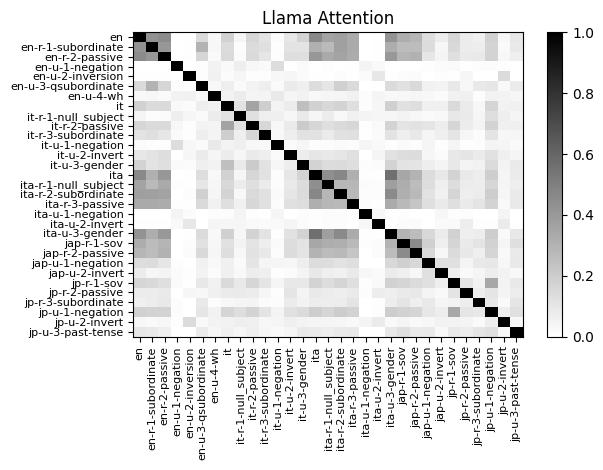

In [43]:
plt.imshow(attn_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(sorted(attn_overlap.columns))), sorted(attn_overlap.columns))
plt.yticks(range(len(sorted(attn_overlap.index))), sorted(attn_overlap.index))
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
# plt.grid(True)
plt.colorbar()
plt.title('Llama Attention')
plt.tight_layout()
# plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/attn-overlap.png')
plt.show()

In [36]:
len( attn[(attn['en'] == attn['en']) & (attn['en'] == 1)] )/ len(attn[(attn['en'] == 1)])

1.0

In [ ]:
# columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
# filtered_columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']
og = pd.read_csv('/home/gridsan/arunas/broca/data-gen/ngs.csv')
columns = [col for col in og.columns if not 'ng-' in col]
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in sorted(columns):
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/new-prompt-{col}-top1-percent.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
# mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[sorted(columns)]

mlp_overlap = pd.DataFrame(columns=sorted(mlp.columns), index=sorted(mlp.columns))

for col in sorted(mlp.columns):
    for col1 in sorted(mlp.columns):
        mlp_overlap.loc[(mlp_overlap.index == col), col1] = float(( (mlp[col] == mlp[col1]) & (mlp[col] != 0) ).sum()/len(mlp))
    mlp_overlap[col] = mlp_overlap[col].astype(float)

plt.imshow(mlp_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp_overlap.columns)), sorted(mlp_overlap.columns))
plt.yticks(range(len(mlp_overlap.index)), sorted(mlp_overlap.index))
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
# plt.grid(True)
plt.colorbar()
plt.title('Confusion Matrix')
plt.tight_layout()
# plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-overlap.png')
plt.show()

## Distribution of activations of all neurons

In [71]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
layer31 = []
layer0 = []
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, index=range(32), columns=range(4096))
        layer31.append(df[df.index==31].values[0,:])
        layer0.append(df[df.index==0].values[0,:])

/state/partition1/slurm_tmp/25169865.0.0/ipykernel_1432574/3215867080.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation=90)


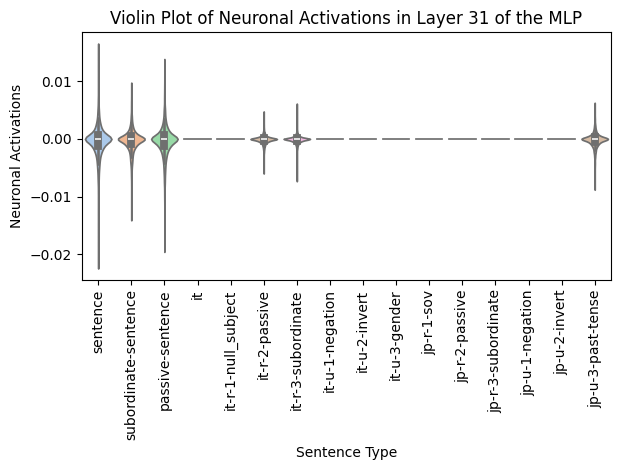

In [72]:


ax = sns.violinplot(data=layer31,  palette="pastel")
ax.set_xticklabels(columns, rotation=90)
plt.xlabel('Sentence Type')
plt.ylabel('Neuronal Activations')
plt.title('Violin Plot of Neuronal Activations in Layer 31 of the MLP')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-neuron-dists.png')
plt.show()

In [73]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
attn = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
attn['neuron'] = np.arange(0,4096)
attn[columns] = 0
attn['layer'] = 31
layer31 = []
layer0 = []
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, index=range(32), columns=range(4096))
        layer31.append(df[df.index==31].values[0,:])
        layer0.append(df[df.index==0].values[0,:])

/state/partition1/slurm_tmp/25169865.0.0/ipykernel_1432574/2836353760.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(columns, rotation=90)


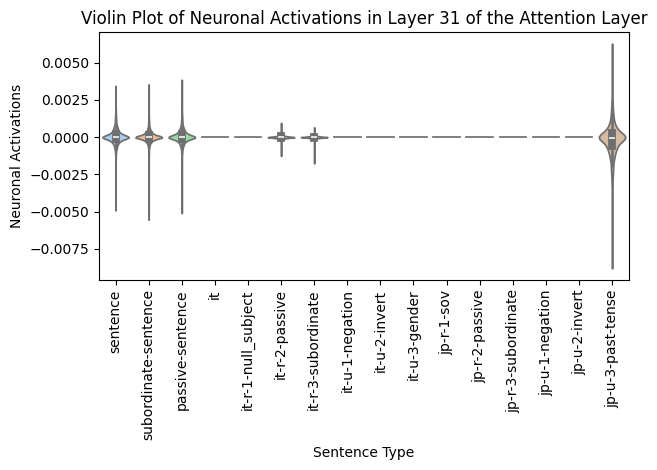

In [74]:


ax = sns.violinplot(data=layer31,  palette="pastel")
ax.set_xticklabels(columns, rotation=90)
plt.xlabel('Sentence Type')
plt.ylabel('Neuronal Activations')
plt.title('Violin Plot of Neuronal Activations in Layer 31 of the Attention Layer')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/attn/attn-neuron-dists.png')
plt.show()

## All neurons confusion matrix

In [75]:
columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it', 'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',    'jp-u-2-invert', 'jp-u-3-past-tense']
filtered_columns = ['sentence', 'subordinate-sentence', 'passive-sentence', 'it-r-2-passive', 'it-r-3-subordinate', 'jp-u-3-past-tense']
mlp = pd.DataFrame(columns=columns+ ['layer', 'neuron'])
mlp['neuron'] = np.arange(0,4096)
mlp[columns] = 0
mlp['layer'] = 31
for col in columns:
    with open(f'/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/{col}-all-neurons.pkl', 'rb') as f:
        x = pickle.load(f)
        x = x.cpu()
        df = pd.DataFrame(x, columns=['layer', 'neuron'])
        for idx, row in df.iterrows():
            mlp.loc[(mlp['neuron'] == row['neuron']) & (mlp['layer'] == row['layer']), col] = 1
# mlp = mlp[~(mlp[columns] == 0).all(axis=1)]
mlp = mlp[columns]

mlp_overlap = pd.DataFrame(columns=mlp.columns, index=mlp.columns)

for col in mlp.columns:
    for col1 in mlp.columns:
        mlp_overlap.loc[(mlp_overlap.index == col), col1] = float(( (mlp[col] == mlp[col1]) & (mlp[col] != 0) ).sum()/len(mlp))
    mlp_overlap[col] = mlp_overlap[col].astype(float)

plt.imshow(mlp_overlap, cmap='binary', aspect='auto', interpolation='nearest')
plt.xticks(range(len(mlp_overlap.columns)), mlp_overlap.columns)
plt.yticks(range(len(mlp_overlap.index)), mlp_overlap.index)
plt.xticks(fontsize=8, rotation=90)  # Set x-axis tick label font size
plt.yticks(fontsize=8)  # Set y-axis tick label font size
# plt.grid(True)
plt.colorbar()
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/home/gridsan/arunas/broca/mistral/mistral-attr-patch-scripts/mlp/mlp-overlap-all.png')
plt.show()

ValueError: Shape of passed values is (32, 4096), indices imply (32, 2)